In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_footsteps_accelerations_absolute
%store -r Y_footsteps_accelerations_absolute
%store -r X_footsteps_continuous_absolute
%store -r Y_footsteps_continuous_absolute
X_motion = np.concatenate((X_footsteps_accelerations_absolute, X_footsteps_continuous_absolute))
Y_motion = np.concatenate((Y_footsteps_accelerations_absolute, Y_footsteps_continuous_absolute))
print(X_motion.shape)
print(Y_motion.shape)

(6143, 28)
(6143, 4)


# Multivariate Linear Regression (Foot prediction)

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [7]:
## Entries where FL is swinging
idxs = np.where(X_motion[:, 21] == 1)[0]
X_motion_FL_swinging = X_motion[idxs]
Y_motion_FL_swinging = Y_motion[idxs]

## Predict FL foot -> x

In [8]:
X_motion_FL_swinging.shape

(3086, 28)

In [9]:
Y_motion_FL_swinging.shape

(3086, 4)

In [10]:
X_motion_FL_swinging[0, :]

array([ 0.1       ,  0.        ,  0.        ,  0.04429445, -0.0763995 ,
        0.02945058, -0.0146854 ,  0.00673978,  0.01790485,  0.22657506,
        0.18870623, -0.4303382 ,  0.24251341, -0.17037205, -0.43098021,
       -0.23804776,  0.16513788, -0.42953227, -0.2633686 , -0.13826779,
       -0.43035149,  1.        ,  0.        ,  0.        ,  1.        ,
        0.1       ,  0.        ,  0.        ])

In [11]:
Y_motion_FL_swinging[0, :]

array([ 0.01997748, -0.00154138,  0.02591898, -0.00928865])

### Linear Regression

In [12]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # prev velocity command
               X_motion_FL_swinging[:, -3:], # commanded velocity command
               X_motion_FL_swinging[:, 9:11], # FL (x,y) position
               X_motion_FL_swinging[:, 12:14], # FR (x,y) position
               X_motion_FL_swinging[:, 15:17], # RL (x,y) position
               X_motion_FL_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_x = LinearRegression()

# Fit the model
model_fl_relative_support_x.fit(X_train, Y_train)
    
# Predict
predictions = model_fl_relative_support_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9981039461253753
RMSE:  0.0016041688349189356
The lowest error is:  8.265755677139275e-08
The highest error is:  0.02154736473365823
The avg. error is:  0.0007980484008704344


In [13]:
model_fl_relative_support_x.coef_

array([[ 2.12405952e-04, -2.77555756e-17, -5.55111512e-17,
         2.14983569e-01, -8.32667268e-17, -5.55111512e-17,
        -2.79901546e-01,  3.67153335e-01,  8.90326423e-02,
        -2.09595211e-01,  8.14745963e-02, -7.94048845e-02,
        -1.69858356e-02, -3.55939494e-01]])

In [16]:
model_fl_relative_support_x.intercept_

array([-0.0895945])

Text(0, 0.5, 'Predictions')

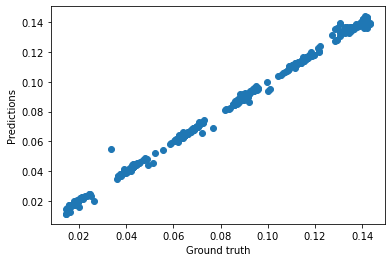

In [17]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [18]:
#%store model_fl_relative_support_x

In [19]:
#for idx, prediction in enumerate(predictions):
#    print(f'Start: {X_test[idx, 6]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [20]:
# Save model
#joblib.dump(model_fl_relative_support_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_x.sav")

### Predict FL foot -> y

In [21]:
# Input
X = np.hstack((X_motion_FL_swinging[:, :3], # prev velocity command
               X_motion_FL_swinging[:, -3:], # commanded velocity command
               X_motion_FL_swinging[:, 9:11], # FL (x,y) position
               X_motion_FL_swinging[:, 12:14], # FR (x,y) position
               X_motion_FL_swinging[:, 15:17], # RL (x,y) position
               X_motion_FL_swinging[:, 18:20])) # RR (x,y) position

# Target
Y = np.array([Y_motion_FL_swinging[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fl_relative_support_y = LinearRegression()

# Fit the model
model_fl_relative_support_y.fit(X_train, Y_train)

# Predict
predictions = model_fl_relative_support_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.8354814178708182
RMSE:  0.000995136519343832
The lowest error is:  6.337217001162188e-08
The highest error is:  0.011909373606211068
The avg. error is:  0.0005917100417591907


In [22]:
model_fl_relative_support_y.coef_

array([[ 3.84205183e-03, -7.28583860e-17,  2.77555756e-17,
         2.47058922e-02,  1.04083409e-17,  0.00000000e+00,
         2.97413228e-01,  4.07457989e-02, -8.76821489e-02,
         1.65017261e-01, -6.73048322e-02, -3.82785402e-02,
        -1.68168627e-01, -2.70623064e-01]])

In [23]:
model_fl_relative_support_y.intercept_

array([-0.12480851])

Text(0, 0.5, 'Predictions')

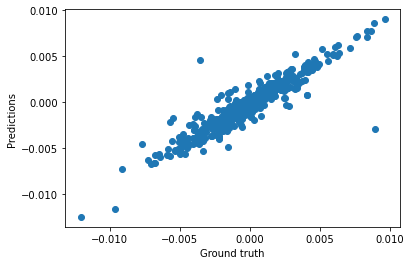

In [24]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Ground truth")
plt.ylabel("Predictions")

In [25]:
#%store model_fl_relative_support_y

In [43]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [44]:
# Save model
#joblib.dump(model_fl_relative_support_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/relative/model_fl_relative_support_y.sav")